In [109]:
from torch._tensor import Tensor
from torch.utils.data import Dataset
from utils import read_npy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import MSELoss
import torchvision.transforms as transforms

class PixelDataset(Dataset):
    def __init__(self, sprites_path, labels_path) -> None:
        self.sprites = read_npy(sprites_path)
        self.labels = read_npy(labels_path)

        self.transform = transforms.Lambda(
                    lambda x: x / 255.
                )  # Normalize to range [-1, 1]

    def __len__(self) -> int:
        return len(self.sprites)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image = self.transform(self.sprites[index].permute(2, 0, 1))
        label = self.labels[index]
        return image, label

In [110]:
from torch.utils.data import DataLoader

In [111]:
dataset = PixelDataset("../dataset/sprites.npy", "../dataset/sprites_labels.npy")
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

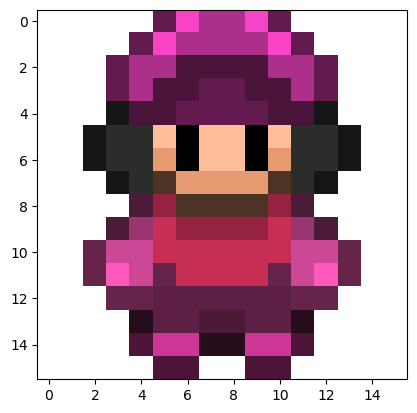

In [117]:
plt.imshow(dataset[0][0].permute(1,2,0))

In [112]:
len(dataset)
print(dataset[0][0].max())
print(dataset[0][0].min())

tensor(1.)
tensor(0.)


In [113]:
for image, label in dataloader:
    print(image[0].shape)
    print(label)
    break

torch.Size([3, 16, 16])
tensor([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])


In [76]:
from models.autoencoder import Encoder, Decoder


In [8]:
encoder = Encoder()
decoder = Decoder()
autoencoder = nn.Sequential(encoder, decoder)


In [9]:
# output = autoencoder(next(iter(dataloader))[0])
# output = torch.stack([image.permute(2,0,1).int() for image in output])
# grid = make_grid(output, nrow=4, padding = 2)
# plt.imshow(grid.permute(1,2,0))
# plt.show()

In [102]:
subset = torch.utils.data.Subset(dataset, range(32))
# print(len(dataset))
dataloader = DataLoader(subset, batch_size=4, shuffle=True, num_workers=0)


In [26]:

optimizer = Adam(autoencoder.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

NameError: name 'autoencoder' is not defined

In [77]:

def get_gradient_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [78]:
def train_loop(dataloader, model, loss_fn, optimizer, epochs=5) -> tuple[list, list]:
    model.train()
    size = len(dataloader.dataset)
    losses = []
    gradients = []
    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            for batch, (X, label) in enumerate(dataloader):
                # Compute prediction error
                pred = model(X)
                loss = loss_fn(pred, X)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()

                
                gradients.append(get_gradient_norm(model))
                losses.append(loss.item())
                if batch % 32 == 0:
                    loss, current = loss.item(), batch * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # scheduler.step()
    except KeyboardInterrupt:
        pass

    return losses, gradients

In [14]:
losses, gradients = train_loop(dataloader, autoencoder, MSELoss(), optimizer, epochs=1)

Epoch 1
-------------------------------
loss: 37802.679688  [    0/89400]
loss: 8651.000977  [ 4992/89400]
loss: 8056.723145  [ 9984/89400]
loss: 7265.149414  [14976/89400]
loss: 5942.890137  [19968/89400]
loss: 5459.165527  [24960/89400]
loss: 5163.061035  [29952/89400]
loss: 5105.179688  [34944/89400]
loss: 4623.454102  [39936/89400]
loss: 5083.098145  [44928/89400]
loss: 4812.738770  [49920/89400]
loss: 4644.868652  [54912/89400]
loss: 4345.795410  [59904/89400]
loss: 4608.004883  [64896/89400]
loss: 4515.396973  [69888/89400]
loss: 4599.203125  [74880/89400]
loss: 4146.195312  [79872/89400]
loss: 4580.081543  [84864/89400]


NameError: name 'torch' is not defined

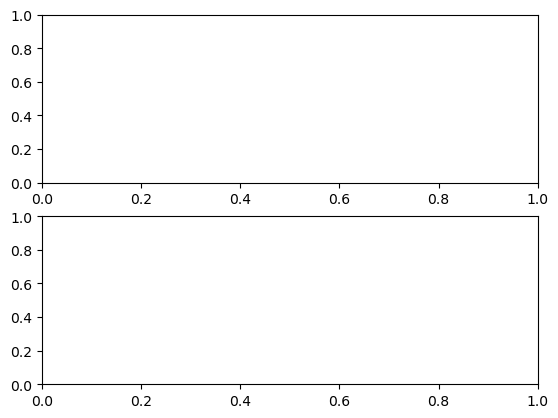

In [4]:

fig, axes = plt.subplots(2)
axes[0].plot(torch.log10(torch.tensor(losses)))
axes[1].plot(gradients)
plt.show()

In [79]:
dataset[0][0]
def show(autoencoder):
    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt
    autoencoder.eval()
    images_not, _ = next(iter(dataloader))
    images = torch.stack([image.int() for image in images_not[:8]])
    print(images[3].int().shape)
    print(images.shape)
    grid = make_grid(images, nrow=4, padding = 2)
    print(grid.shape)
    plt.imshow(grid.permute(1,2,0))

    plt.show()

    autoencoder.eval()
    with torch.no_grad():
        output = autoencoder(images_not[:8])
        output = torch.stack([image.int() for image in output])
        grid = make_grid(output, nrow=4, padding = 2)
        plt.imshow(grid.permute(1,2,0))
        plt.show()

    with torch.no_grad():
        images_not = torch.randn(8,30)
        output = autoencoder.decoder(images_not[:8])
        output = torch.stack([image.int() for image in output])
        grid = make_grid(output, nrow=4, padding = 2)
        plt.imshow(grid.permute(1,2,0))
        plt.show()





# CONV Autoencoder

In [6]:
class ConvEncoder(nn.Module):
    def __init__(self) -> None:
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), padding="same"
            ),  # mx16x16x3 -> mx16x16x16
            nn.MaxPool2d(kernel_size=(2, 2)),  #mx16x8x8
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2,2)), #mx32x8x8
            nn.MaxPool2d(kernel_size=(2, 2), padding=1),  #mx32x4x4
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=(2,2), padding = "same"), #mx64x4x4
            nn.MaxPool2d(kernel_size=(2, 2)), #mx64x2x2,
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=(2,2), padding = "same"), #mx128x2x2
            nn.MaxPool2d(kernel_size=(2, 2)), #mx128x1x1,
            nn.Flatten() # mx128
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [95]:
class ConvDecoder(nn.Module):
    def __init__(self) -> None:
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (-1, 1, 1)),  # mx128x1x1
            nn.Upsample(scale_factor=2),  # mx128x2x2
            nn.Conv2d(128, 64, kernel_size=(2, 2), padding="same"),  # mx128x2x2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=(2, 2), padding="same"),  # mx32x4x4
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, kernel_size=(2, 2), padding="same"),  # mx16x8x8
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=(2, 2), padding="same"),  # mx16x16x16
            # nn.Conv2d(16, 3, kernel_size=(2, 2), padding="same"),  # mx3x16x16
            nn.Flatten(1),
            nn.Linear(16 * 16 * 16, 3 * 16 * 16),
            nn.ReLu(),
            nn.Unflatten(1, (3, 16, 16)),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.decoder(x)
        return x

In [103]:
class ConvEncoder(nn.Module):
    def __init__(self) -> None:
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), padding="same"
            ),  # mx16x16x3 -> mx16x16x16
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),  # mx16x8x8
            # nn.Dropout(0.3),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2)),  # mx32x8x8
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(kernel_size=(2, 2), padding=1),  # mx32x4x4
            # nn.Conv2d(
            #     in_channels=32, out_channels=64, kernel_size=(2, 2), padding="same"
            # ),  # mx64x4x4
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(kernel_size=(2, 2)),  # mx64x2x2,
            # nn.Conv2d(
            #     in_channels=64, out_channels=128, kernel_size=(2, 2), padding="same"
            # ),  # mx128x2x2
            # nn.MaxPool2d(kernel_size=(2, 2)),  # mx128x1x1,
            nn.Flatten(),  # mx128 #mx64x2x2
            nn.Linear(16*8*8, 128),
            nn.LeakyReLU(0.2,inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        return x


class ConvDecoder(nn.Module):
    def __init__(self) -> None:
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (-1, 1, 1)),  # mx128x1x1
            nn.Upsample(scale_factor=2),  # mx128x2x2
            nn.Conv2d(128, 64, kernel_size=(2, 2), padding="same"),  # mx64x2x2
            nn.BatchNorm2d(64),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(64, 32, kernel_size=(2, 2), padding="same"),  # mx32x4x4
            # nn.BatchNorm2d(32),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(32, 16, kernel_size=(2, 2), padding="same"),  # mx16x8x8
            # nn.BatchNorm2d(16),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(16, 16, kernel_size=(2, 2), padding="same"),  # mx16x16x16
            # nn.BatchNorm2d(16),
            # nn.Conv2d(16, 3, kernel_size=(2, 2), padding="same"),  # mx3x16x16
            nn.Flatten(1),
            # nn.Linear(16 * 16 * 16, 3 * 16 * 16),
            nn.Linear(64*2*2, 3 * 16 * 16),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 16, 16)),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.decoder(x)
        return x


class ConvAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()
        self.autoencoder = nn.Sequential(self.encoder, self.decoder)

    def forward(self, x: Tensor) -> Tensor:
        o = self.autoencoder(x)
        return o


In [104]:

images = dataset[0][0].unsqueeze(0)
print(images.shape)
# images, _ = next(iter(dataloader))
conv = ConvEncoder()
out = conv(images)
out.shape
out = torch.cat((out, torch.zeros((255, 128))), dim = 0)
print(out.shape)
dec = ConvDecoder()
dec(out).shape

torch.Size([1, 3, 16, 16])
torch.Size([256, 128])


torch.Size([256, 3, 16, 16])

In [105]:
auto = ConvAutoEncoder()
optimizer = Adam(auto.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)
auto(images).shape

torch.Size([1, 3, 16, 16])

In [106]:
losses, gradients = train_loop(dataloader, auto, MSELoss(), optimizer, epochs=100)

Epoch 1
-------------------------------
loss: 0.176025  [    0/   32]
Epoch 2
-------------------------------
loss: 0.081120  [    0/   32]
Epoch 3
-------------------------------
loss: 0.050965  [    0/   32]
Epoch 4
-------------------------------
loss: 0.061537  [    0/   32]
Epoch 5
-------------------------------
loss: 0.044325  [    0/   32]
Epoch 6
-------------------------------
loss: 0.033973  [    0/   32]
Epoch 7
-------------------------------
loss: 0.044722  [    0/   32]
Epoch 8
-------------------------------
loss: 0.056453  [    0/   32]
Epoch 9
-------------------------------
loss: 0.049681  [    0/   32]
Epoch 10
-------------------------------
loss: 0.051258  [    0/   32]
Epoch 11
-------------------------------
loss: 0.028659  [    0/   32]
Epoch 12
-------------------------------
loss: 0.034248  [    0/   32]
Epoch 13
-------------------------------
loss: 0.037584  [    0/   32]
Epoch 14
-------------------------------
loss: 0.029688  [    0/   32]
Epoch 15
------

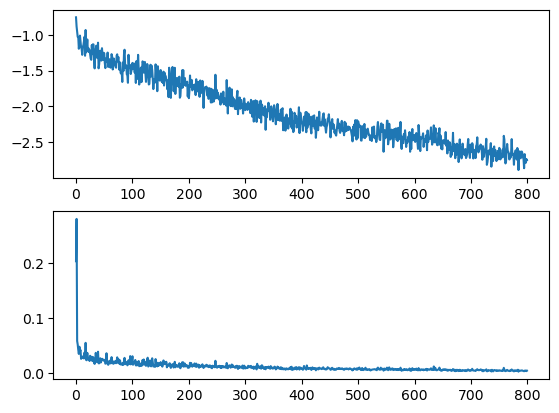

In [107]:

fig, axes = plt.subplots(2)
axes[0].plot(torch.log10(torch.tensor(losses)))
axes[1].plot(gradients)
plt.show()

torch.Size([3, 16, 16])
torch.Size([4, 3, 16, 16])
torch.Size([3, 20, 74])


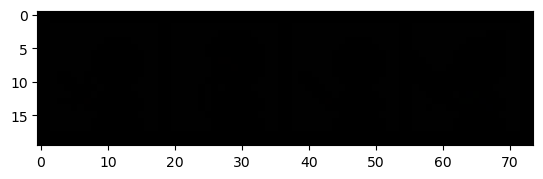

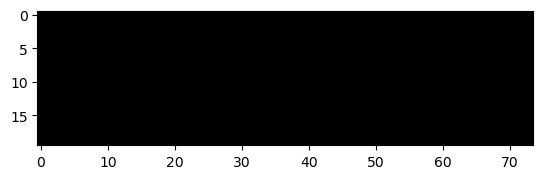

RuntimeError: Given groups=1, weight of size [64, 128, 2, 2], expected input[8, 30, 3, 3] to have 128 channels, but got 30 channels instead

In [108]:
show(auto)